In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_utils import reconstruct_signal_cosine
from scipy.fftpack import dct
from sklearn.decomposition import NMF

In [2]:
data_path = "data/"
collection = "ONeillsJigs"

In [3]:
# load the dataframe
df = pd.read_pickle(f"{data_path}{collection}_parsed.pkl")

In [4]:
numtunes = df.shape[0]
Fs = 6.0 # samples per quaver
params = {'legend.fontsize': 'x-large',
      'figure.figsize': (10, 5),
     'axes.labelsize': 'x-large',
     'axes.titlesize':'x-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

idx_tunes = [15, 357]
for idx_tune in idx_tunes:
    print(df.title[idx_tune])

When sick is it tea you want?
Go to the Devil and shake yourself


In [5]:
def nmf_reconstruction(contours, nmf, dim):
    coeff = nmf.transform(contours)
    coeff[:, dim+1:] = 0
    reconstruction = nmf.components_.T @ coeff.T
    return reconstruction

In [6]:
# estimate a nmf from all the tunes
nmf = NMF(n_components=70)
# get all TimePitchTune from df
contours = df['TimePitchTune'].values
# pad with zeros to have the same length
max_len = max([len(c) for c in contours])
contours = [np.pad(c, (0, max_len-len(c)), 'constant') for c in contours]
# reshape the contours
contours = np.array([np.array(c) for c in contours])
# fit the nmf
nmf.fit(contours)

NMF(n_components=70)

Tune n°: 16 
Title: When sick is it tea you want?


/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


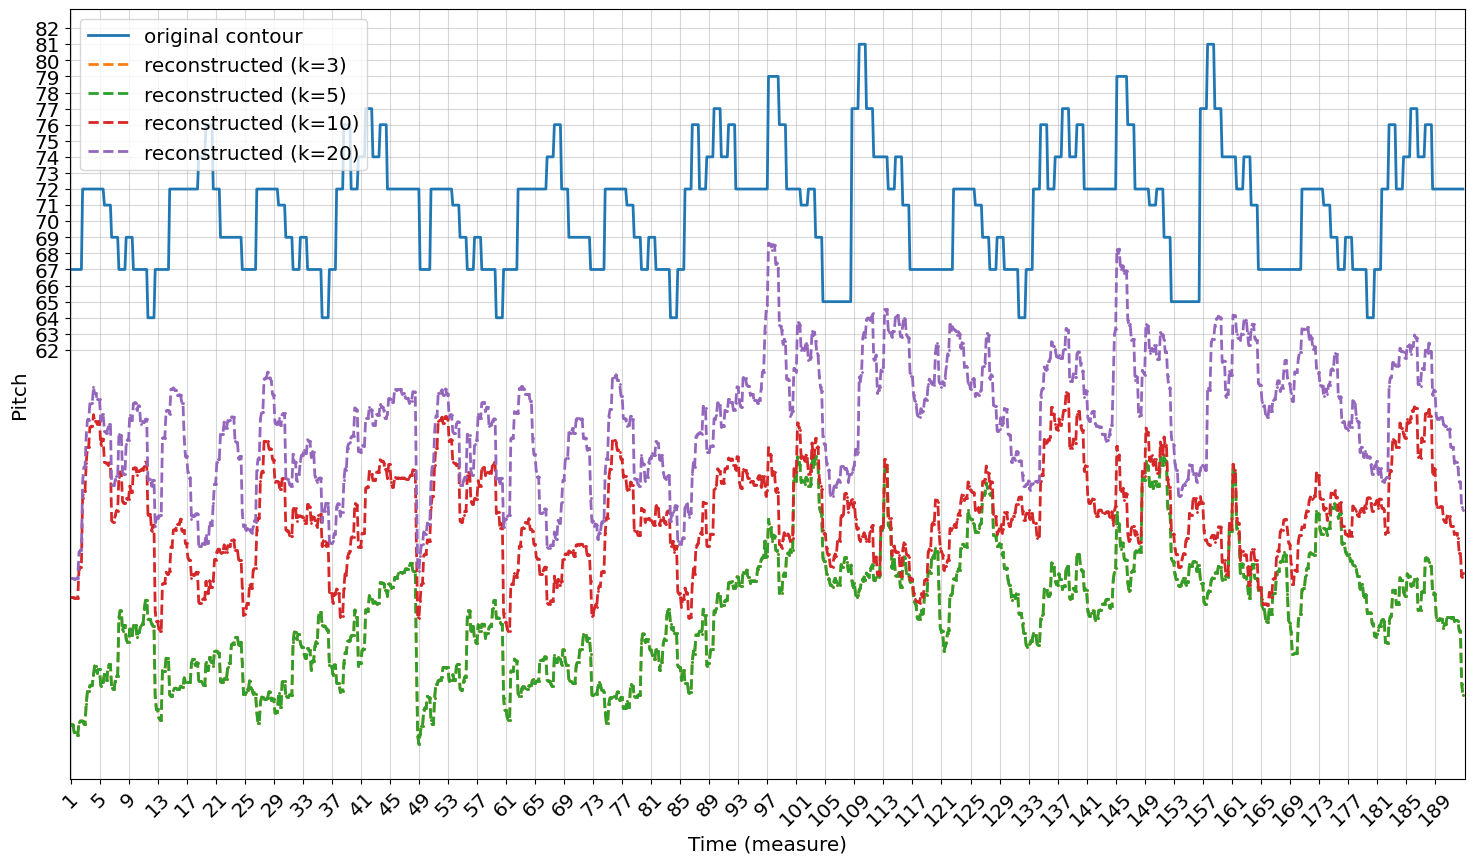

Tune n°: 358 
Title: Go to the Devil and shake yourself


/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


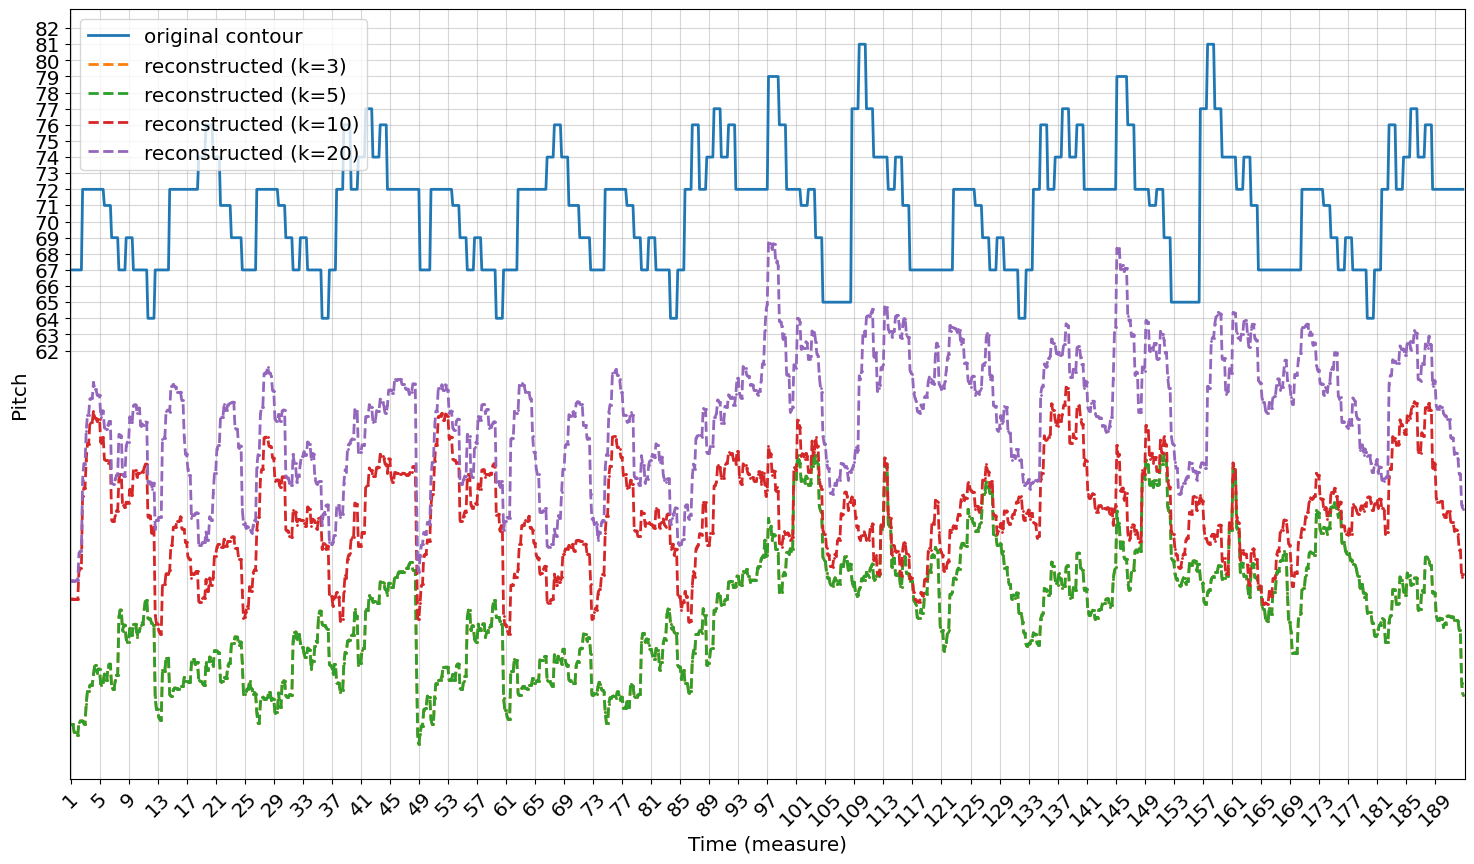

In [7]:
resolutions = [3, 5, 10, 20]

for idx_tune in idx_tunes:
    TimePitchTune = df.TimePitchTune[idx_tune]
    len_tune = len(TimePitchTune)

    print("Tune n°:", idx_tune+1, "\nTitle:", df.title[idx_tune])
    tt = np.arange(0, len(TimePitchTune))

    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Plot the original contour
    ax.plot(1 + tt/6, TimePitchTune, '-', lw=2, ms=2, label='original contour')

    # Plot reconstructed signals for different values of k
    for res in resolutions:
        # Pad with zeros to have the same length and reshape for nmf
        TimePitchTune_padded = np.pad(TimePitchTune, (0, max_len - len(TimePitchTune)), 'constant')
        reconstruction = nmf_reconstruction(TimePitchTune_padded.reshape(1, -1), nmf, res).flatten()

        # Cut the reconstruction to the original length
        reconstruction = reconstruction[:len_tune]
        
        # Plot the reconstructed contour with dotted lines
        ax.plot(1 + tt/6, reconstruction, '.--', lw=2, ms=2, label=f'reconstructed (k={res})')

    plt.xticks(np.arange(1,len_tune/Fs+1,4),rotation=45)
    
    plt.xlabel("Time (measure)")
    plt.ylabel("Pitch")
    plt.xlim((0.9,len_tune/Fs+1.1))
    
    plt.yticks(np.arange(62,83,1))

    # Add grid with transparency
    ax.grid(alpha=0.5)

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()


In [8]:
def get_parts_tune(tune, Fs):
    parts = []
    part_samples = int(6*8*Fs)  # The number of samples per part (6 measures, 8 beats per measure)
    num_parts = int(len(tune) / part_samples)
    for part in range(num_parts):
        tt = np.arange(part * 6 * 8, (part + 1) * 6 * 8, 1.0 / Fs)  # Time array for the part
        init = part * part_samples
        end = (part + 1) * part_samples
        
        parts.append(tune[init:end])
    return parts

In [9]:
# train nmf on parts
nmf_parts = NMF(n_components=70)
# get all TimePitchTune from df
contours = df['TimePitchTune'].values
# get parts for all tunes
Fs = 6.0
parts = [get_parts_tune(tune, Fs) for tune in contours]
# reshape the contours
parts = np.array([np.array(p) for tune_parts in parts for p in tune_parts])
# fit the nmf
nmf_parts.fit(parts)

NMF(n_components=70)

Tune n°: 16 
Parts: 4 
Title: When sick is it tea you want?


/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/

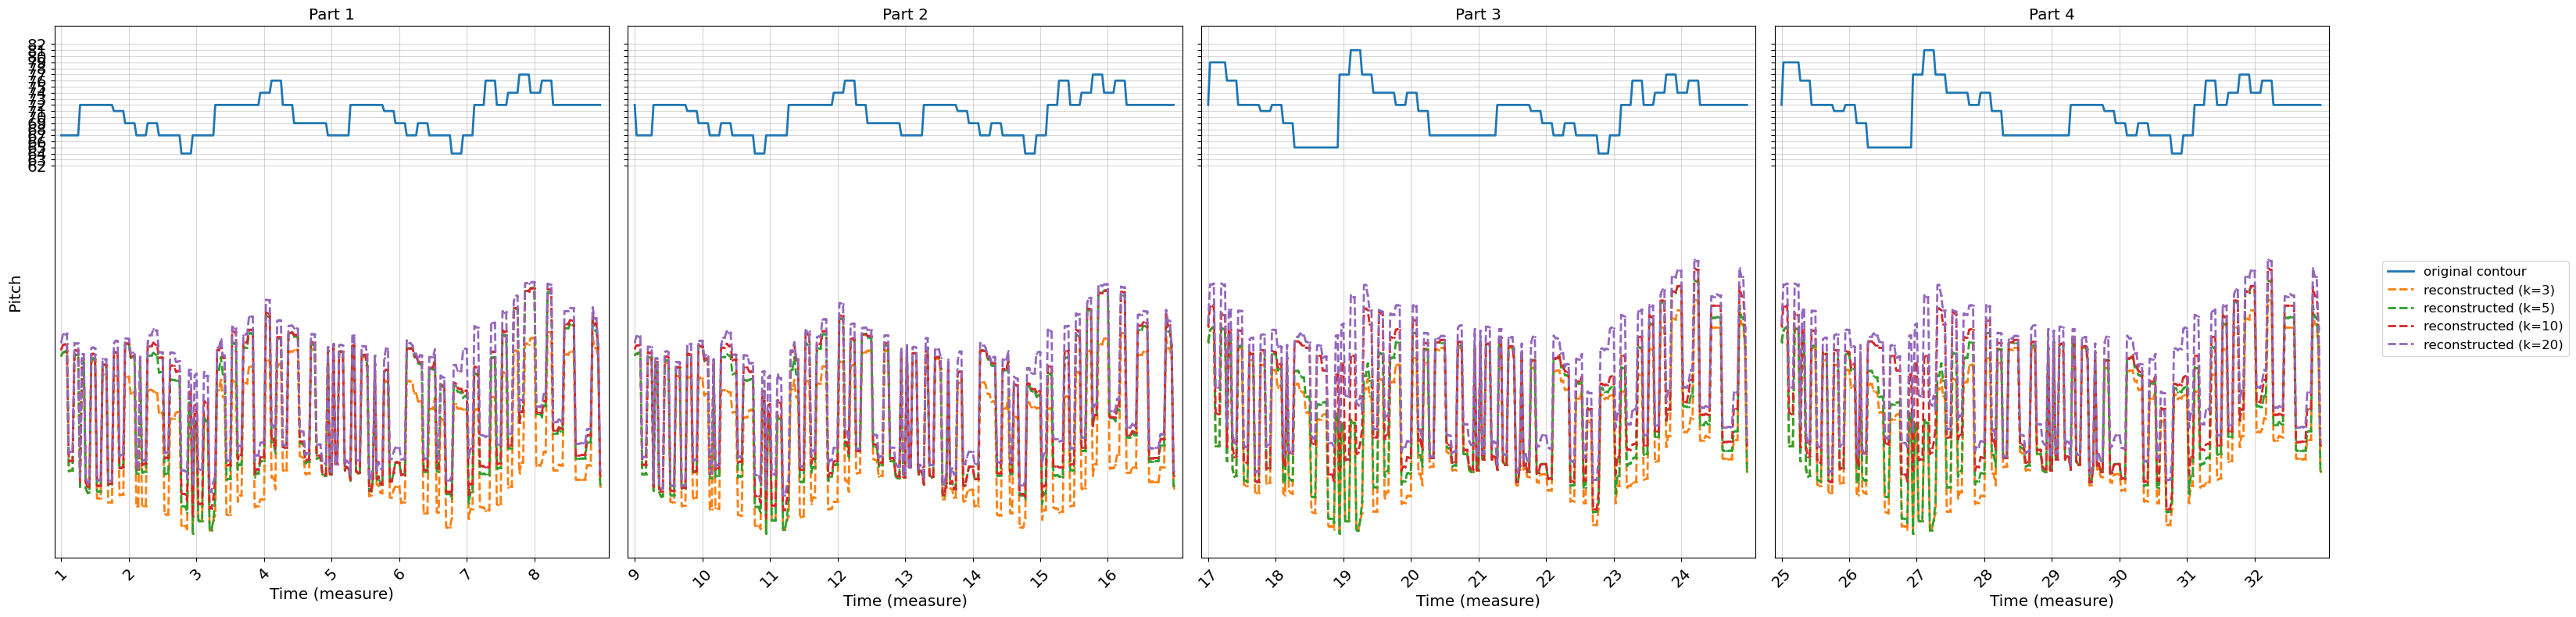

Tune n°: 358 
Parts: 4 
Title: Go to the Devil and shake yourself


/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lcros/anaconda3/envs/melodic-decomposition-ml/lib/python3.13/

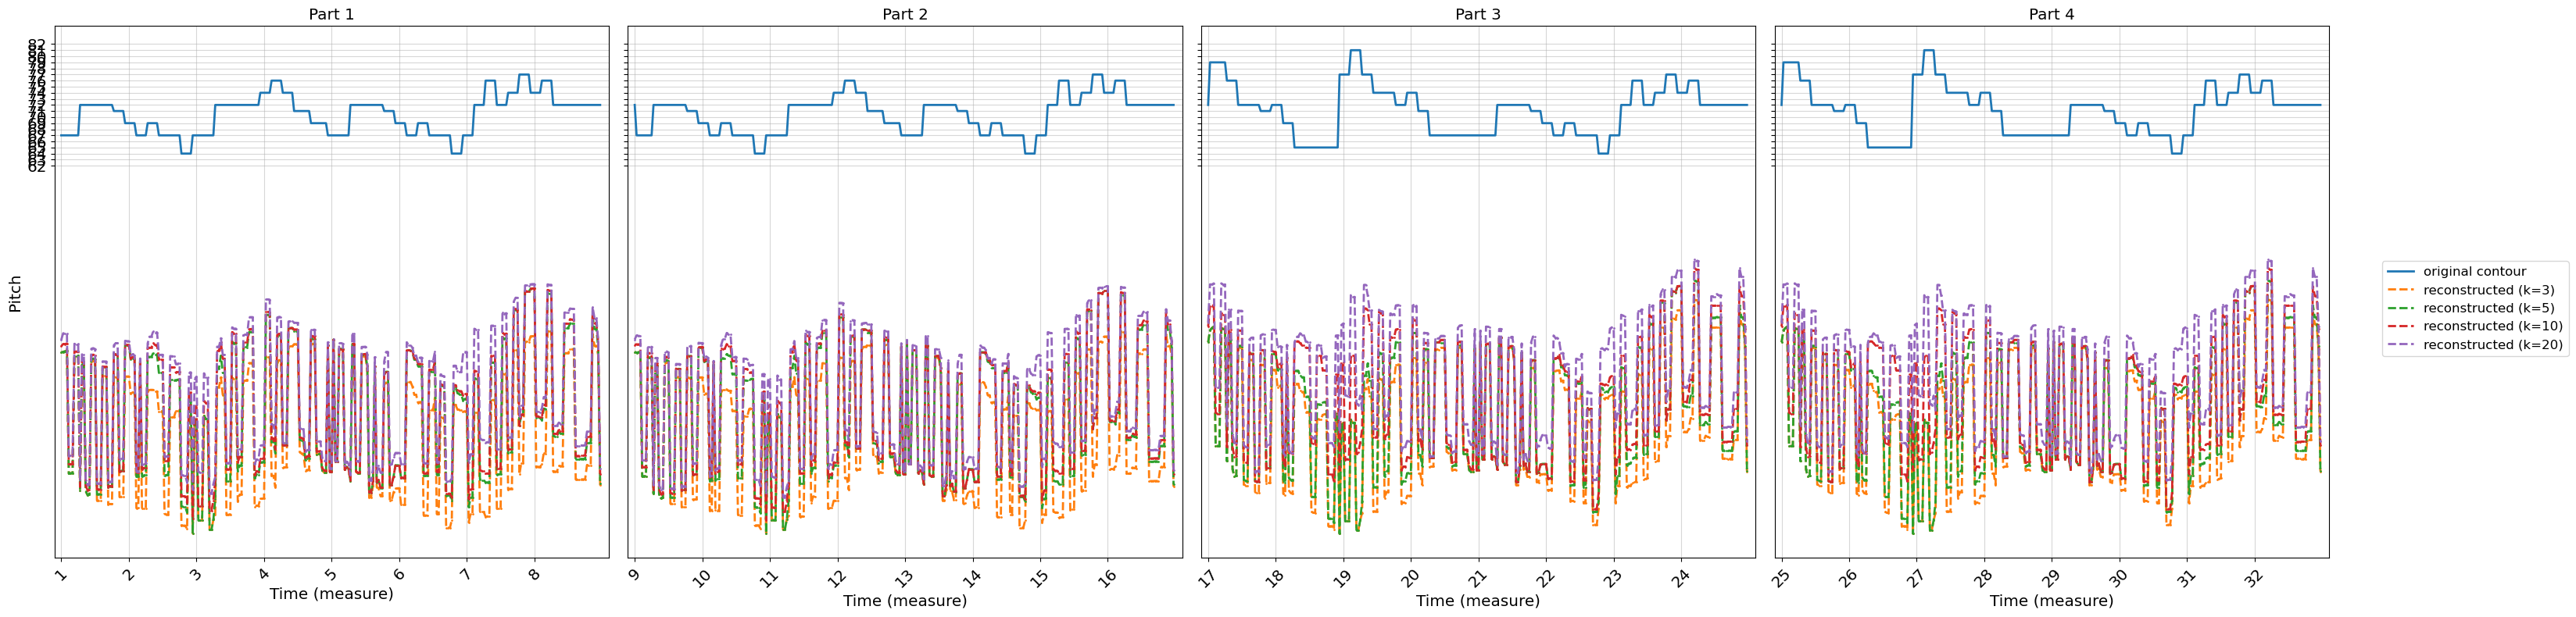

In [10]:
resolutions = [3, 5, 10, 20]

for idx_tune in idx_tunes:
    TimePitchTune = df.TimePitchTune[idx_tune]
    part_samples = int(6*8*Fs)  # The number of samples per part (6 measures, 8 beats per measure)
    num_parts = int(len(TimePitchTune) / part_samples)  # The number of parts in the tune
    print("Tune n°:", idx_tune+1, "\nParts:", num_parts, "\nTitle:", df.title[idx_tune])

    # Create a figure with subplots arranged horizontally (1 row, num_parts columns) and share y-axis
    fig, axes = plt.subplots(1, num_parts, figsize=(30, 8), sharey=True)
    first = True
    for part in range(num_parts):
        tt = np.arange(part * 6 * 8, (part + 1) * 6 * 8, 1.0 / Fs)  # Time array for the part
        init = part * part_samples
        end = (part + 1) * part_samples

        ax = axes[part]  # Use the corresponding axis for this part

        # Plot the original contour
        if first:
            ax.plot(1 + tt / 6, TimePitchTune[init:end], '-', lw=2, ms=2, label='original contour')
        else:
            ax.plot(1 + tt / 6, TimePitchTune[init:end], '-', lw=2, ms=2)

        # Apply nmf to the part (reshape for nmf input)
        TimePitchTune_part = TimePitchTune[init:end]  # Reshape the part into 2D
        # Plot the reconstructed signals for different values of components
        for res in resolutions:
            reconstruction = nmf_reconstruction(TimePitchTune_part.reshape(1, -1), nmf_parts, res).flatten()
                
            # Plot the reconstructed signal
            if first:
                ax.plot(1 + tt / 6, reconstruction, '.--', lw=2, ms=2, label=f'reconstructed (k={res})')
            else:
                ax.plot(1 + tt / 6, reconstruction, '.--', lw=2, ms=2)

        # Set the title of each subplot
        ax.set_title(f"Part {part + 1}")

        # Set x-axis ticks to represent time measures
        ax.set_xticks(np.arange(1 + 8 * part, 8 * (part + 1) + 1, 1))
        ax.set_xticklabels(np.arange(1 + 8 * part, 8 * (part + 1) + 1, 1), rotation=45)

        ax.set_xlabel("Time (measure)")
        if first:
            ax.set_ylabel("Pitch")
        ax.set_xlim((0.9 + 8 * part, 1.1 + 8 * (part + 1)))

        ax.set_yticks(np.arange(62, 83, 1))  # Adjust based on your pitch range
        ax.grid(alpha=0.5)  # Add a grid with some transparency

        first = False

    # Add a single legend for all subplots (only once)
    fig.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), fontsize=12)

    # Adjust spacing between subplots for better visualization
    plt.tight_layout()
    plt.show()

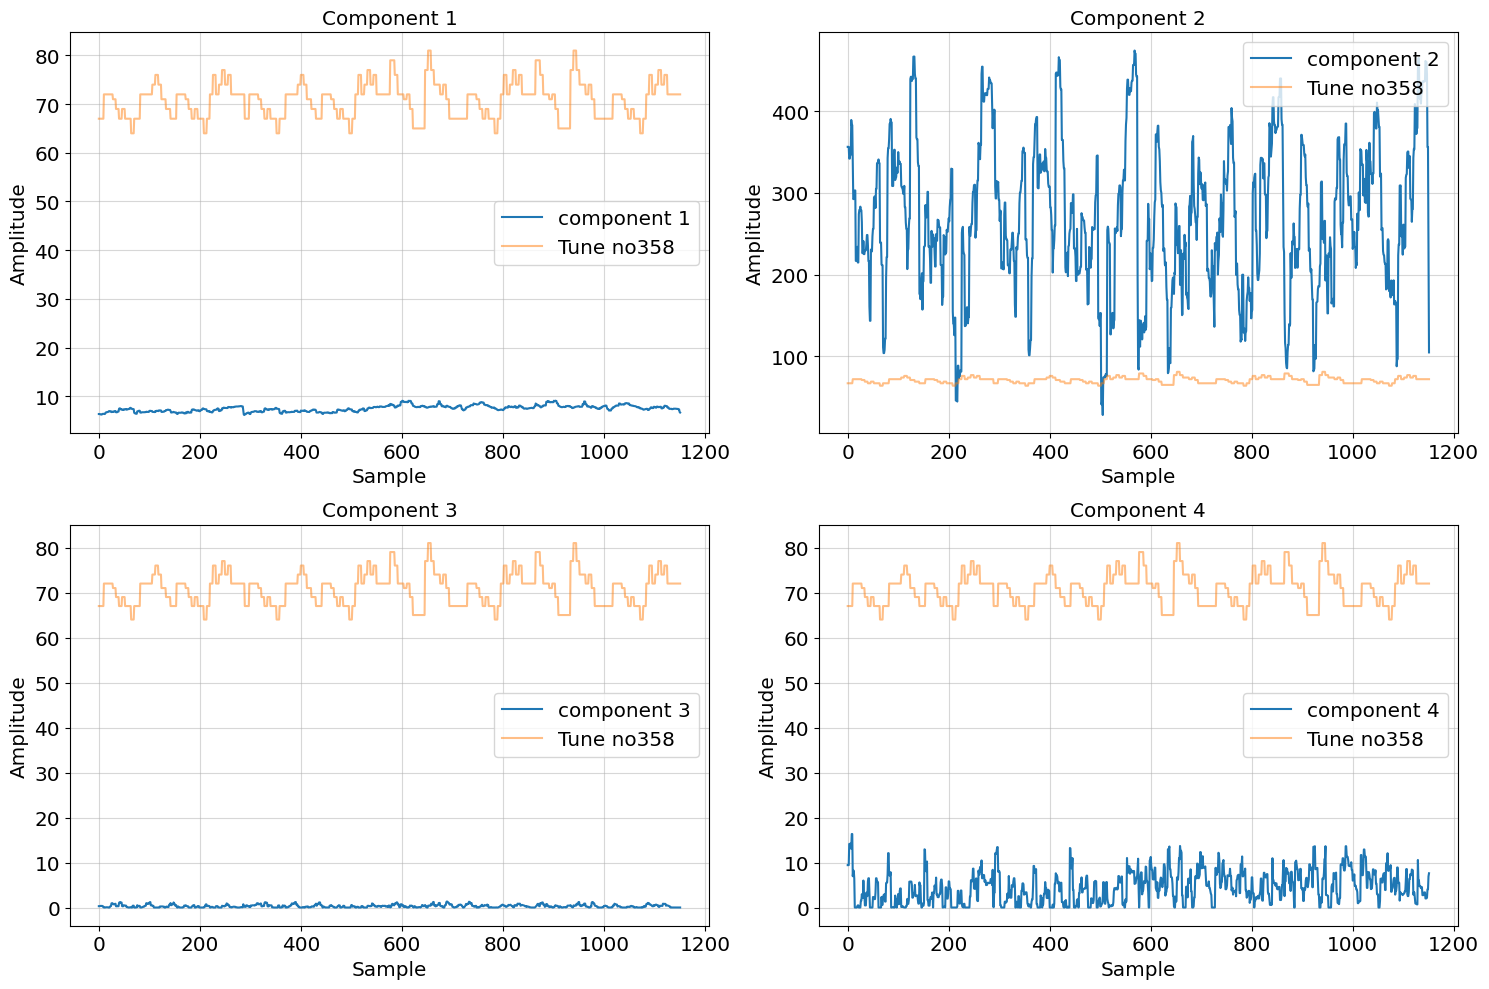

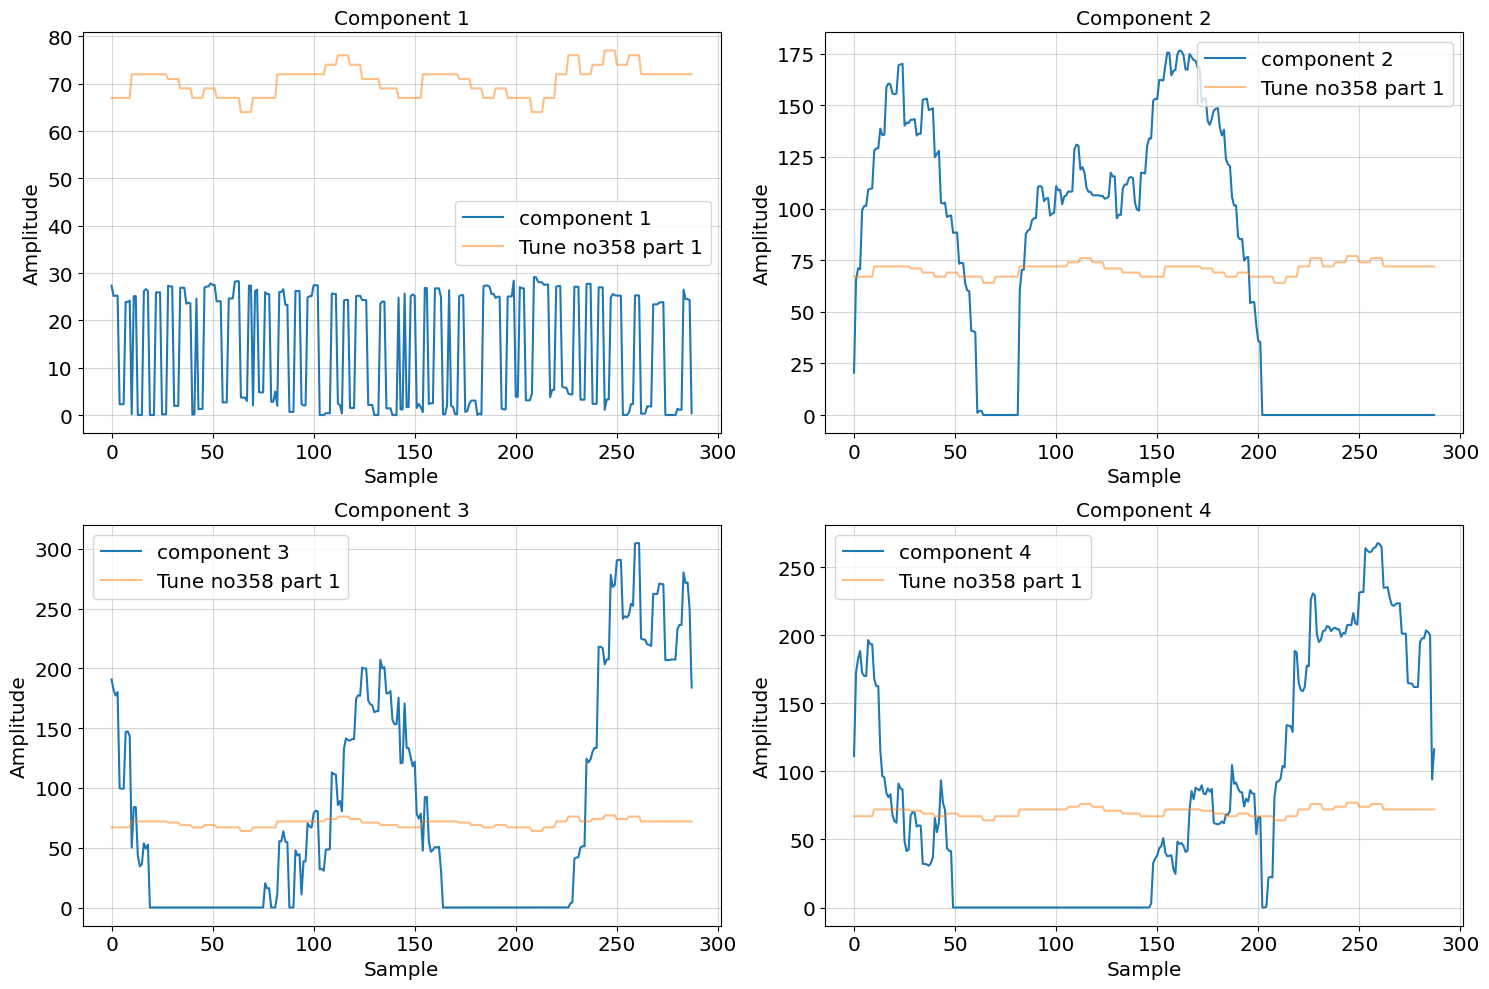

In [12]:
TimePitchTune = df.TimePitchTune[idx_tune]
# plot the first 4 components of the nmf for the whole tune and for the parts of the tune
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for component in range(4):
    ax = axes[component // 2, component % 2]
    scaled_components = nmf.components_
    ax.plot(scaled_components[component][:len(TimePitchTune)], label='component '+str(component+1))
    ax.plot(TimePitchTune, alpha=0.5, label='Tune no'+str(idx_tune+1))
    ax.set_title(f'Component {component + 1}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Amplitude')
    ax.legend()

    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

tune_part = TimePitchTune[:part_samples]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for component in range(4):
    ax = axes[component // 2, component % 2]
    scaled_components = nmf_parts.components_ 
    ax.plot(scaled_components[component], label='component '+str(component+1))
    ax.plot(tune_part, alpha=0.5, label='Tune no'+str(idx_tune+1)+' part 1')
    ax.set_title(f'Component {component + 1}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Amplitude')
    ax.legend()

    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()
